Upload key

In [1]:
from os import system
from google.colab import files
files.upload()
system("cls")

Saving kaggle.json to kaggle.json


32512

Move key to appropiate folder

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Import dataset

In [3]:
!pip install kaggle
!kaggle competitions download -c aptos2019-blindness-detection
!unzip aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

Library

In [ ]:
import numpy as np
import polars as pl
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
from keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB5, EfficientNetV2S, EfficientNetB4, DenseNet121, DenseNet169, DenseNet201, VGG19, ResNet50, ResNet50V2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory
from tensorflow.image import flip_left_right, adjust_brightness, adjust_contrast
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb
from PIL import Image
from tqdm import tqdm

Data preview

In [ ]:
dftr = pl.read_csv("./train.csv")
dfts = pl.read_csv("./test.csv")
print(dftr.head())
print(dfts.head())
labels = ["Normal", "Mild", "Moderate", "Severe", "Proliferative"]
fig = plt.figure(figsize=(60, 60))
for id in range(5):
    label = labels[id]
    ft = dftr.filter(dftr["diagnosis"] == id).sample(1, seed=8485)
    hx = ft["id_code"][0]
    path = f'./train_images/{hx}.png'
    sf = fig.add_subplot(5, 5, id * 5 + 1, xticks=[], yticks=[])
    img = cv2.imread(path)[:,:,::-1]
    plt.imshow(img)
    sf.set_title(f'Image {hx}: {label}')

In [ ]:
!mkdir ./pimages
def crop(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis=1), mask.any(axis=0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(axis=1), mask.any(axis=0))]
            img2 = img[:, :, 1][np.ix_(mask.any(axis=1), mask.any(axis=0))]
            img3 = img[:, :, 2][np.ix_(mask.any(axis=1), mask.any(axis=0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img
def filter1(image, sigmaX=10):
    image = cv2.resize(image, (224, 224))
    image =cv2.addWeighted (image, 4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
    return image
for x in tqdm(os.listdir("train_images")):
    path = f'./train_images/{x}'
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    image = crop(image)
    image = filter1(image)
    cv2.imwrite(f'./pimages/{x}', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

100%|██████████| 3662/3662 [12:45<00:00,  4.78it/s]


Group image based on their class in a separate folder

In [ ]:
!rm -r ./images
!mkdir -p ./images/{Normal,Mild,Moderate,Severe,Proliferative}
for x in tqdm(os.listdir("pimages")):
    '''
    shutil.copy(f'./train_images/{x}', f'./images/{labels[dftr.filter(dftr["id_code"] == x.split(".")[0])["diagnosis"][0]]}')
    os.rename(f'./images/{labels[dftr.filter(dftr["id_code"] == x.split(".")[0])["diagnosis"][0]]}/{x}', f'./images/{labels[dftr.filter(dftr["id_code"] == x.split(".")[0])["diagnosis"][0]]}/{x.split(".")[0]+"_o"+".png"}')
    '''
    shutil.copy(f'./pimages/{x}', f'./images/{labels[dftr.filter(dftr["id_code"] == x.split(".")[0])["diagnosis"][0]]}')

rm: cannot remove './images': No such file or directory


100%|██████████| 3662/3662 [00:02<00:00, 1254.79it/s]


Dataset for training and validation

In [ ]:
batch = 32
seed = 578

tdg = ImageDataGenerator(
    validation_split = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    brightness_range = (10, 20),
    zoom_range = 0.2,
    fill_mode = "nearest"
)

vdg = ImageDataGenerator(
    validation_split = 0.15
)

tds = tdg.flow_from_directory(
    "images",
    target_size=(224, 224),
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
    subset="training",
    seed=seed,
    classes=["Normal", "Mild", "Moderate", "Severe", "Proliferative"]
)

vds = vdg.flow_from_directory(
    "images",
    target_size=(224, 224),
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
    subset="validation",
    seed=seed,
    classes=["Normal", "Mild", "Moderate", "Severe", "Proliferative"]
)


Found 3116 images belonging to 5 classes.
Found 546 images belonging to 5 classes.


Creating the model

In [ ]:
model = VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
# for layer in model.layers:
#     layer.trainable = False
model = Sequential([
    model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(5, activation="softmax")
])
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss=CategoricalCrossentropy(),
    metrics=["Accuracy"]
)
StopParams = EarlyStopping(patience=5, monitor="val_accuracy", mode="min", min_delta=0.001)
model.fit(
    tds,
    epochs=15,
    validation_data=vds,
    #callbacks=[StopParams],
    verbose=1
)
for i in range(len(model.layers)-3):
    model.layers[i].trainable = False
model.fit(
    tds,
    epochs=5,
    validation_data=vds,
    verbose=1
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - Accuracy: 0.4125 - loss: 2.1749 - val_Accuracy: 0.4945 - val_loss: 1.3105
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 120s 731ms/step - Accuracy: 0.4979 - loss: 1.2774 - val_Accuracy: 0.4945 - val_loss: 1.5065
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 730ms/step - Accuracy: 0.5379 - loss: 1.2024 - val_Accuracy: 0.4945 - val_loss: 2.2755
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 750ms/step - Accuracy: 0.6020 - loss: 1.0834 - val_Accuracy: 0.4945 - val_loss: 2.0307
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 757ms/step - Accuracy: 0.6257 - loss: 1.0626 - val_Accuracy: 0.4945 - val_loss: 3.3894
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 750ms/step - Accuracy: 0.6532 - loss: 1.0071 - val_Accuracy: 0.4945 - val_loss: 3.7901
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 733ms/step - Accuracy: 0.6429 - loss: 1.0017 - val_Accuracy: 0.4945 - val_loss: 3.3292
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 733ms/step - Accuracy: 0.6620 - loss: 0.9790 - val_Accuracy: 0.4945

Confusion Matrix

98/98 ━━━━━━━━━━━━━━━━━━━━ 58s 580ms/step


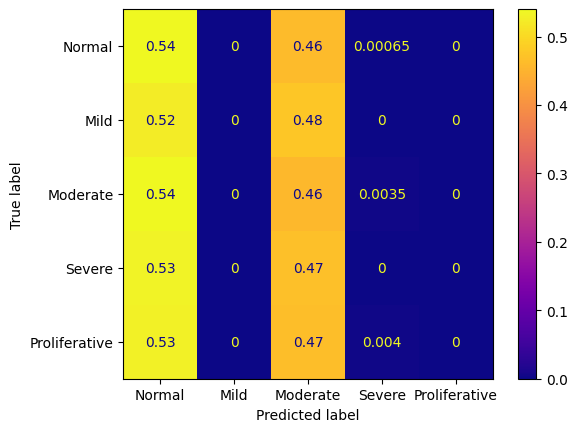

In [ ]:
yp = model.predict(tds).argmax(axis=1)
yt = tds.classes
cm = confusion_matrix(yt, yp)
cm = cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tds.class_indices.keys()).plot(cmap="plasma")

Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[9.9287534e-01 3.8945902e-04 3.5014362e-03 2.9527565e-04 2.9385185e-03]]
Predicted: Normal with confidence of 99.2875%


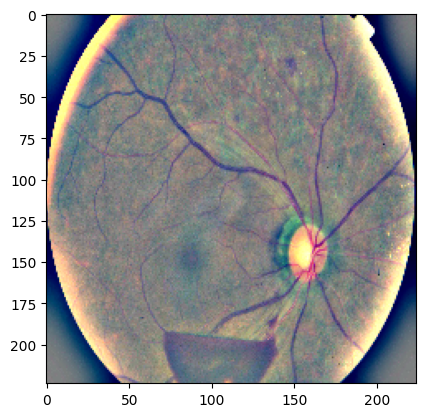

In [ ]:
typ = "Proliferative"
dir = os.listdir(f'./images/{typ}')
rnd = dir[random.randint(0, len(dir)-1)]
img = Image.open(f'./images/{typ}/{rnd}')
img = img.resize((224, 224))
plt.imshow(img)
img = np.asarray(img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=batch, verbose=1)
print(prediction)
res = np.argmax(prediction)
print(f'Predicted: {labels[res]} with confidence of {prediction[0][res]:.4%}')

Exporting the model

In [ ]:
name = "modeleb090ish.h5"
model.save(name)
files.download(f'./{name}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>